Necessary libraries

In [7]:
import pandas as pd
import numpy as np
import csv 
import matplotlib.pyplot as plt

from pandas import read_csv
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit # cross validation split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import warnings
import seaborn as sns


## Preprocessing data

In [2]:
# Reading in the dataset
df = pd.read_csv('03-Oct-2023_patAnalysis_2.csv')

In [3]:
# Data without interepolation

# Remove NaN values of PAT
df_squashed = df.dropna(subset=['wrist@(9mm,809nm)_filtered_pat_bottomTI'])
#Remove rows of NaN values of blood pressure
df_squashed = df_squashed.dropna(subset = ["blood pressure_systolic"])
df_squashed

,"wrist@(9mm,809nm)_date","wrist@(9mm,809nm)_delay_s","wrist@(9mm,809nm)_raw_pat","wrist@(9mm,809nm)_filtered_pat_bottomTI","wrist@(9mm,809nm)_mask",blood pressure_systolic,blood pressure_mean,blood pressure_diastolic
31,27/10/2022 10:49,29.016,NaN,0.415027,1,73.6288,52.06840,45.20960
44,27/10/2022 10:49,40.335,0.415027,0.372815,1,94.0030,65.08525,52.00100
51,27/10/2022 10:49,46.522,0.329416,0.369593,1,97.9044,67.67830,53.90440
63,27/10/2022 10:49,60.487,0.307726,0.311529,1,100.6974,69.77305,56.69740
74,27/10/2022 10:49,69.969,0.316886,0.310813,1,100.2031,69.60155,56.60155
...,...,...,...,...,...,...,...,...
2321,27/10/2022 11:52,3798.134,0.180315,0.185350,1,116.1598,80.15980,60.96650
2322,27/10/2022 11:52,3799.034,0.181337,0.185817,1,115.8898,79.88980,60.74150
2323,27/10/2022 11:52,3799.944,0.186739,0.186459,1,115.6168,79.61680,60.51400
2324,27/10/2022 11:52,3800.842,0.190720,0.187216,1,115.3474,79.34740,60.28950


In [31]:
# Identify outliers of column by z-score
z = np.abs(stats.zscore(df_squashed['wrist@(9mm,809nm)_filtered_pat_bottomTI']))

# Identify outliers as pat_filtered with a z-score greater than 3
threshold = 3
outliers = df_squashed['wrist@(9mm,809nm)_filtered_pat_bottomTI'][z > threshold]

# Print the outliers
print(outliers)

# Remove outliers
df_squashed = df_squashed.drop(outliers.index)
df_squashed

Series([], Name: wrist@(9mm,809nm)_filtered_pat_bottomTI, dtype: float64)


,"wrist@(9mm,809nm)_date","wrist@(9mm,809nm)_delay_s","wrist@(9mm,809nm)_raw_pat","wrist@(9mm,809nm)_filtered_pat_bottomTI","wrist@(9mm,809nm)_mask",blood pressure_systolic,blood pressure_mean,blood pressure_diastolic
63,27/10/2022 10:49,60.487,0.307726,0.311529,1,100.6974,69.77305,56.69740
74,27/10/2022 10:49,69.969,0.316886,0.310813,1,100.2031,69.60155,56.60155
77,27/10/2022 10:49,72.733,NaN,0.309751,1,99.9267,69.46335,56.46335
78,27/10/2022 10:49,73.720,0.204559,0.308952,1,99.8280,69.41400,56.41400
79,27/10/2022 10:49,74.702,NaN,0.308108,1,99.7298,69.36490,56.36490
...,...,...,...,...,...,...,...,...
2321,27/10/2022 11:52,3798.134,0.180315,0.185350,1,116.1598,80.15980,60.96650
2322,27/10/2022 11:52,3799.034,0.181337,0.185817,1,115.8898,79.88980,60.74150
2323,27/10/2022 11:52,3799.944,0.186739,0.186459,1,115.6168,79.61680,60.51400
2324,27/10/2022 11:52,3800.842,0.190720,0.187216,1,115.3474,79.34740,60.28950


In [30]:
# Interpolated dataframe

# Performing interpolation on filtered PAT, still using pandas dataframe
#data_squashed_2 = df.dropna(subset=['wrist@(9mm,809nm)_filtered_pat_bottomTI'])
time = df['wrist@(9mm,809nm)_delay_s']

interp_func = interp1d(df_squashed['wrist@(9mm,809nm)_delay_s'].array, df_squashed['wrist@(9mm,809nm)_filtered_pat_bottomTI'].array, kind='linear', fill_value="extrapolate")

pat_filt_int = interp_func(time) #Numpy array
df['filtered_pat_interpolated'] = pat_filt_int.tolist()
df = df.dropna(subset=['blood pressure_systolic'])
df

,"wrist@(9mm,809nm)_date","wrist@(9mm,809nm)_delay_s","wrist@(9mm,809nm)_raw_pat","wrist@(9mm,809nm)_filtered_pat_bottomTI","wrist@(9mm,809nm)_mask",blood pressure_systolic,blood pressure_mean,blood pressure_diastolic,filtered_pat_interpolated
24,27/10/2022 10:49,22.626,NaN,NaN,0,62.1268,44.71990,41.3756,0.314385
25,27/10/2022 10:49,23.482,NaN,NaN,0,63.6676,45.70430,41.8892,0.314321
26,27/10/2022 10:49,24.377,0.539193,NaN,0,65.2786,46.73355,42.4262,0.314253
27,27/10/2022 10:49,25.307,NaN,NaN,0,66.9526,47.80305,42.9842,0.314183
28,27/10/2022 10:49,26.263,0.725741,NaN,0,68.6734,48.90245,43.5578,0.314111
...,...,...,...,...,...,...,...,...,...
2321,27/10/2022 11:52,3798.134,0.180315,0.185350,1,116.1598,80.15980,60.9665,0.185350
2322,27/10/2022 11:52,3799.034,0.181337,0.185817,1,115.8898,79.88980,60.7415,0.185817
2323,27/10/2022 11:52,3799.944,0.186739,0.186459,1,115.6168,79.61680,60.5140,0.186459
2324,27/10/2022 11:52,3800.842,0.190720,0.187216,1,115.3474,79.34740,60.2895,0.187216


In [32]:
# Splitting of the dataset into training and test set
X_sq, y_sq = df_squashed['wrist@(9mm,809nm)_filtered_pat_bottomTI'].to_numpy().reshape(-1, 1), df_squashed['blood pressure_systolic'].to_numpy().reshape(-1, 1)
X, y = df['filtered_pat_interpolated'].to_numpy().reshape(-1, 1), df['blood pressure_systolic'].to_numpy().reshape(-1, 1)

X_train_sq, X_test_sq, y_train_sq, y_test_sq = train_test_split(X_sq, y_sq, test_size = 0.3, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Polynomial  regression

In [33]:
# Basis for the model
poly = PolynomialFeatures(degree=2, include_bias=False)
# Polynomial transform of squashed X
poly_f_sq = poly.fit_transform(X_sq)
poly_f= poly.fit_transform(X)

#Splitting data in train and test set
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(poly_f, y, test_size=0.3, random_state=42)
X_train_sq, X_test_sq, y_train_sq, y_test_sq = train_test_split(poly_f_sq, y_sq, test_size=0.3, random_state=42)

In [34]:
# For the non interpolated data
poly_mod_sq = LinearRegression()

poly_mod_sq.fit(X_train_sq, y_train_sq)

poly_pred_sq = poly_mod_sq.predict(X_test_sq)
poly_rmse_sq = np.sqrt(mean_squared_error(y_test_sq, poly_pred_sq))
poly_r2_sq = poly_mod_sq.score(X_test_sq, y_test_sq)

print("For polynomial regression   non innterpolated PAT: ")
print("Root mean squared error:  ", poly_rmse_sq)
print("R2  squared: ", poly_r2_sq)

For polynomial regression   non innterpolated PAT: 
Root mean squared error:   11.130521927902548
R2  squared:  0.5406962684577843


In [35]:
# For the interpolated data

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_p, y_train_p)

poly_reg_y_pred = poly_reg_model.predict(X_test_p)
poly_reg_rmse = np.sqrt(mean_squared_error(y_test_p, poly_reg_y_pred))
poly_reg_r2 = poly_reg_model.score(X_test_p, y_test_p)

#  Polynomial  regression with inverse X
poly_features_inv = poly.fit_transform(1/X)
X_train_inv, X_test_inv, y_train_inv, y_test_inv = train_test_split(poly_features_inv, y, test_size=0.3, random_state=42)
poly_inv_mod = LinearRegression()
poly_inv_mod.fit(X_train_inv, y_train_inv)
poly_inv_pred =  poly_inv_mod.predict(X_test_inv)
poly_inv_rmse = mean_squared_error(y_test_inv, poly_inv_pred, squared = False)
poly_inv_r2 = poly_inv_mod.score(X_test_inv, y_test_inv)

print("Root mean squared error:  ", poly_reg_rmse)
print("R2  squared: ", poly_reg_r2)
print("Root mean squared error  with  inverted PAT:  ", poly_inv_rmse)
print("R2  squared inverted PAT: ", poly_inv_r2)

Root mean squared error:   15.162130238995928
R2  squared:  0.3356602649059319
Root mean squared error  with  inverted PAT:   15.17651809047907
R2  squared inverted PAT:  0.33439883838542017


## Polynomial  regression with rolling time series cross validation

In [36]:
# Set the window size for the rolling time series cross-validation

def poly_rolling(window_size, poly_features, y_ar):
    """Takes in:
    window_size = size of the window
    poly_features = polynomial feature matrix
    y  = the true values
    """
    
    n_features = len(poly_features)

    # Initialize empty arrays to store MSE and RMSE values and also predictions and  actual  values for each fold
    mse_scores = np.zeros(n_features-window_size)
    rmse_scores = np.zeros(n_features-window_size)
    preds = np.zeros(n_features-window_size)
    test = np.zeros(n_features-window_size)


    # Perform rolling time series cross-validation
    for i in range(n_features - window_size):
        # Split the data into training and testing sets using the rolling window


        X_train_rolling, X_test_rolling = poly_features[i:i+window_size], poly_f[i+window_size:i+window_size+1]
        y_train_rolling, y_test_rolling = y_ar[i:i+window_size], y_ar[i+window_size:i+window_size+1]

        # Initialize and train the polynomial regression model
        poly_reg_model = LinearRegression()
        poly_reg_model.fit(X_train_rolling, y_train_rolling)

        # Make predictions on the test set
        poly_reg_y_pred = poly_reg_model.predict(X_test_rolling)
        # Fold MSE 
        fold_mse = mean_squared_error(y_test_rolling, poly_reg_y_pred)
        # Calculate RMSE for this fold and append it to the list of RMSE scores
        fold_rmse = np.sqrt(fold_mse)

        
        
        mse_scores[i] = fold_mse
        rmse_scores[i] = fold_rmse
        preds[i] = poly_reg_y_pred
        test[i] = y_test_rolling
        

    # Calculate the average RMSE across all folds
    average_mse = np.mean(mse_scores)
    average_rmse = np.mean(rmse_scores)


    #Print the average RMSE
    
    print("Average RMSE:", average_rmse)
    return average_rmse, preds, test

In [24]:
# For non interpolated 
rolling_p_sq, preds_sq, true_sq = poly_rolling(60, poly_f_sq, y_sq)

Average RMSE: 15602.41197522083


In [37]:
# For interpolated PAT
rolling_p, preds_p,true_p = poly_rolling(60, poly_f, y)

Average RMSE: 2.5334588494007133


## Plotting to investigate different  winndow sizes affect on RMSE

In [14]:
window_sizes  = [20,60,90,120,150,180,210,240, 270, 300]
av_RMSEs = np.zeros(len(window_sizes))

for i in range(len(window_sizes)):
    rmse, preds, true = poly_rolling(window_sizes[i], poly_f, y)
    av_RMSEs[i] = rmse



Average RMSE: 1.176817686026475
Average RMSE: 2.845310462224285
Average RMSE: 4.096296374822033
Average RMSE: 5.18544643534046
Average RMSE: 5.723780644946861
Average RMSE: 6.654167575667373
Average RMSE: 7.609280566984006
Average RMSE: 8.196003137217811
Average RMSE: 8.83825735326297
Average RMSE: 9.668334569844793


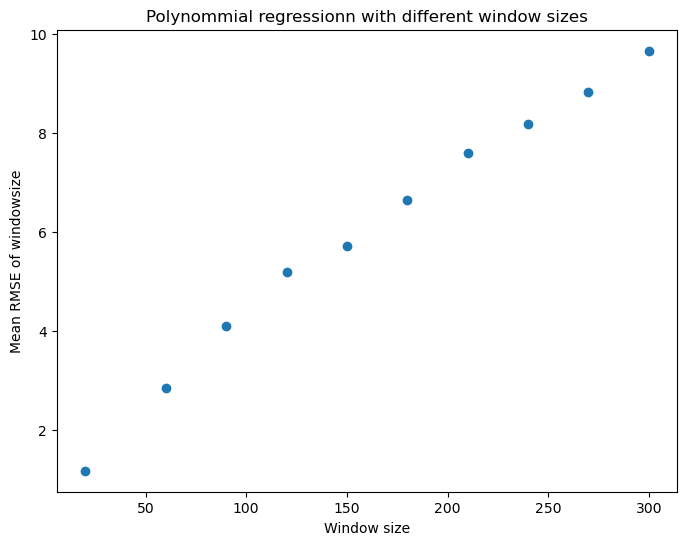

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(window_sizes, av_RMSEs)
plt.xlabel('Window size')
plt.ylabel('Mean RMSE of windowsize')
plt.title('Polynommial regressionn with different window sizes')
plt.show()

In [26]:
# Plot individual fold results
def plot_ind_folds(true, predicted, title):
    
    fig = plt.figure(figsize=(12, 6))
    plt.scatter(range(len(true)), true, color='blue', label='Actual', alpha=0.5)
    plt.scatter(range(len(predicted)), predicted, color='red', label='Predicted', alpha=0.5)
    plt.xlabel('Sample Index')
    plt.ylabel('Systolic Blood Pressure')
    plt.title('Individual Fold Results - Actual vs. Predicted  '+ title)
    plt.legend()
    plt.show()


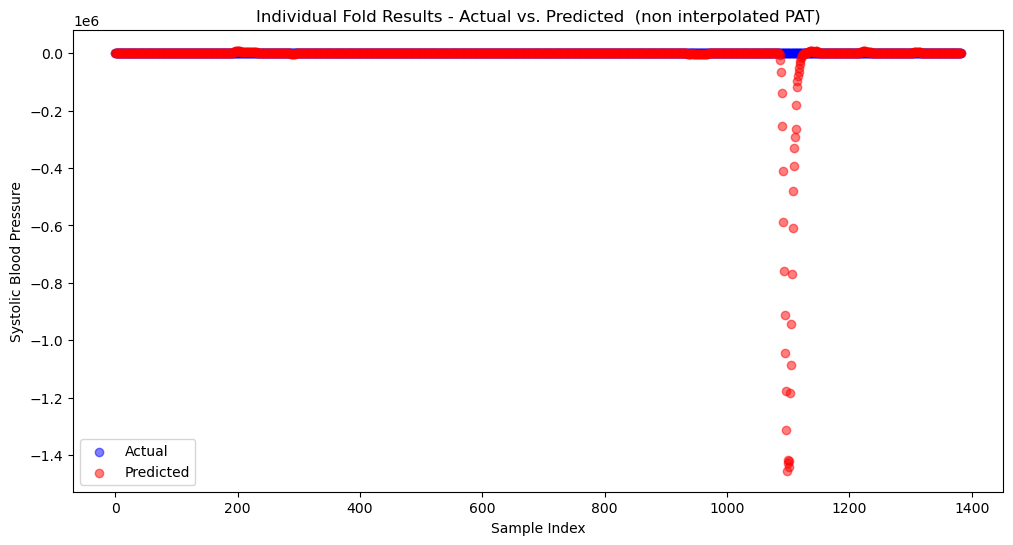

In [27]:
plot_ind_folds(true_sq, preds_sq, "(non interpolated PAT)")

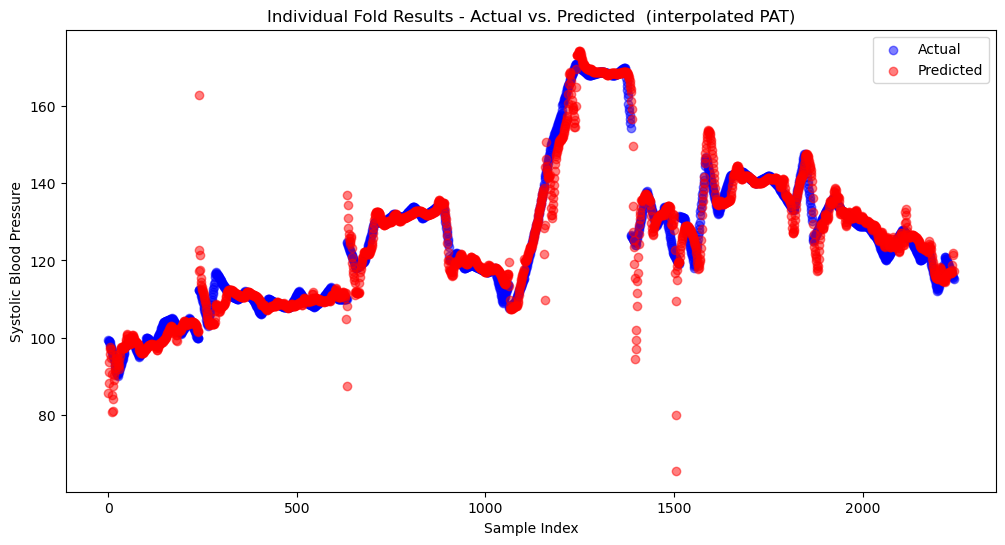

In [38]:
plot_ind_folds(true_p, preds_p, "(interpolated PAT)")